## ODYSEA Swath Simulator Examples

This notebook contains examples for constructing an ODYSEA orbital swath, co-locating model data, and adding expected instrument errors.

These simplified simulations are part of a much larger WaCM simulation capability at JPL, where the actual instrument, sampling, and science performance are generated.

Want to contrubite? Please do! Ask wineteer@jpl.nasa.gov how to get involved.

## Imports and classes

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from odysim.swath_sampling import OdyseaSwath
from odysim.errors import OdyseaErrors
from odysim.colocate_model import GriddedModel, addTimeDim
from odysim.utils import makePlot

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import datetime
import itertools

font = {'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

matplotlib.rc('font', **font)
matplotlib.rc('lines',linewidth=4)
matplotlib.rc('text',usetex=False)

matplotlib.rcParams.update({"axes.grid" : True, "grid.color": "black"})

## Initialize the ODYSEA swath object
Orbit_fname contains an orbit propagated using the orbit height in the filename.
config_fname most importantly contains the swath width to be used for swath generation. A swath is generated and centered on the propagated orbit nadir point.

In [3]:
odysea = OdyseaSwath(orbit_fname='../odysim/orbit_files/orbit_out_2020_2023_height590km.npz',
                     config_fname='../odysim/wacm_sampling_config.py')

## Create an orbit generator object between two dates
Note that the provided orbit is currently 2020-2023 at 590 km height in a 4AM/PM sun-synchronous orbit.

In [4]:
start_time = datetime.datetime.strptime('2020-01-22:12','%Y-%M-%d:%H')
end_time = datetime.datetime.strptime('2020-01-25:12','%Y-%M-%d:%H')

orbits = odysea.getOrbits(start_time = start_time,end_time = end_time)

## Grab the first xarray dataset orbit
The orbit iterator we created above contains all orbits that exist between the two chosen start/end dates. 
Actual orbital swath data is generated on the fly whenever next() is called. A for/while loop can also be used to iterate through each orbit inside the orbits iterator.
Each orbit swath will be returned as an xarray dataset containing information about sample time/lat/lon and antenna pointing information.

In [5]:
%%time
o = next(orbits)
display(o)

<xarray.Dataset>
Dimensions:         (along_track: 8706, cross_track: 334)
Coordinates:
  * along_track     (along_track) int64 0 1 2 3 4 5 ... 8701 8702 8703 8704 8705
  * cross_track     (cross_track) int64 0 1 2 3 4 5 ... 328 329 330 331 332 333
Data variables:
    sample_time     (along_track, cross_track) datetime64[ns] 2020-01-22T20:3...
    lat             (along_track, cross_track) float32 -79.02 -79.05 ... -81.85
    lon             (along_track, cross_track) float32 1.74 1.567 ... 4.81 5.125
    swath_blanking  (cross_track) bool True True True True ... True True True
    encoder_fore    (along_track, cross_track) float64 -90.0 -83.72 ... 90.0
    encoder_aft     (along_track, cross_track) float64 -90.0 -96.28 ... 90.0
    azimuth_fore    (along_track, cross_track) float64 -90.0 -83.72 ... -46.51
    azimuth_aft     (along_track, cross_track) float64 -90.0 -96.28 ... -46.51
    bearing         (along_track) float64 9.095e-06 -83.34 ... -136.6 -136.5
Attributes: (12/14)
    title:                Odysea Simple Orbit Sampling V0.1
    project:              Odysea
    summary:              Simplified orbit sampling assuming basic Odysea orb...
    references:           Rodriguez 2018, Wineteer 2020
    institution:          Jet Propulsion Laboratory (JPL)
    creator_name:         Alexander Wineteer
    ...                   ...
    geospatial_lat_min:   -89.99N
    geospatial_lat_max:   89.99N
    geospatial_lon_min:   -180.00E
    geospatial_lon_max:   180.00E
    time_coverage_start:  2020-01-22 20:37:00.000878
    time_coverage_end:    2020-01-22 22:11:58.873014

CPU times: user 14.1 s, sys: 117 ms, total: 14.2 s
Wall time: 14.3 s


## Create a gridded model object to hold model data
The included GriddedModel class is designed to take in lat/lon gridded data and is used to interpolate to orbital swath data. Modify the GriddedModel class as neccessary to support your own model dataset. Much more documentation on how this work is in the GriddedModel code.

In [6]:
model = GriddedModel(preprocess=addTimeDim,n_files=200)
display(model.U)

<xarray.Dataset>
Dimensions:  (time: 200, lat: 4501, lon: 9000)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-19T21:00:00 ... 2020-01-28T04:00:00
  * lat      (lat) float64 -90.0 -89.96 -89.92 -89.88 ... 89.88 89.92 89.96 90.0
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    U        (time, lat, lon) float64 dask.array<chunksize=(1, 4501, 9000), meta=np.ndarray>

## Co-locate model currents and winds to the orbit swath
This code will add numerous wind and current variables into the orbit swath object. u_model, v_model, u10_model, v10_model, tx_model, ty_mode, wind_speed_model, wind_dir_model. Tx is wind stress. U10 is 10 meter wind. u is currents.

In [7]:
o = model.colocateSwathCurrents(o)
o = model.colocateSwathWinds(o)
display(o)

<xarray.Dataset>
Dimensions:           (along_track: 8706, cross_track: 334)
Coordinates:
  * along_track       (along_track) int64 0 1 2 3 4 ... 8701 8702 8703 8704 8705
  * cross_track       (cross_track) int64 0 1 2 3 4 5 ... 329 330 331 332 333
Data variables: (12/17)
    sample_time       (along_track, cross_track) datetime64[ns] 2020-01-22T20...
    lat               (along_track, cross_track) float32 -79.02 ... -81.85
    lon               (along_track, cross_track) float32 1.74 1.567 ... 5.125
    swath_blanking    (cross_track) bool True True True True ... True True True
    encoder_fore      (along_track, cross_track) float64 -90.0 -83.72 ... 90.0
    encoder_aft       (along_track, cross_track) float64 -90.0 -96.28 ... 90.0
    ...                ...
    u10_model         (along_track, cross_track) float64 nan nan nan ... nan nan
    v10_model         (along_track, cross_track) float64 nan nan nan ... nan nan
    tx_model          (along_track, cross_track) float64 nan nan nan ... nan nan
    ty_model          (along_track, cross_track) float64 nan nan nan ... nan nan
    wind_speed_model  (along_track, cross_track) float64 nan nan nan ... nan nan
    wind_dir_model    (along_track, cross_track) float64 nan nan nan ... nan nan
Attributes: (12/14)
    title:                Odysea Simple Orbit Sampling V0.1
    project:              Odysea
    summary:              Simplified orbit sampling assuming basic Odysea orb...
    references:           Rodriguez 2018, Wineteer 2020
    institution:          Jet Propulsion Laboratory (JPL)
    creator_name:         Alexander Wineteer
    ...                   ...
    geospatial_lat_min:   -89.99N
    geospatial_lat_max:   89.99N
    geospatial_lon_min:   -180.00E
    geospatial_lon_max:   180.00E
    time_coverage_start:  2020-01-22 20:37:00.000878
    time_coverage_end:    2020-01-22 22:11:58.873014

## Look at these model data in the swath

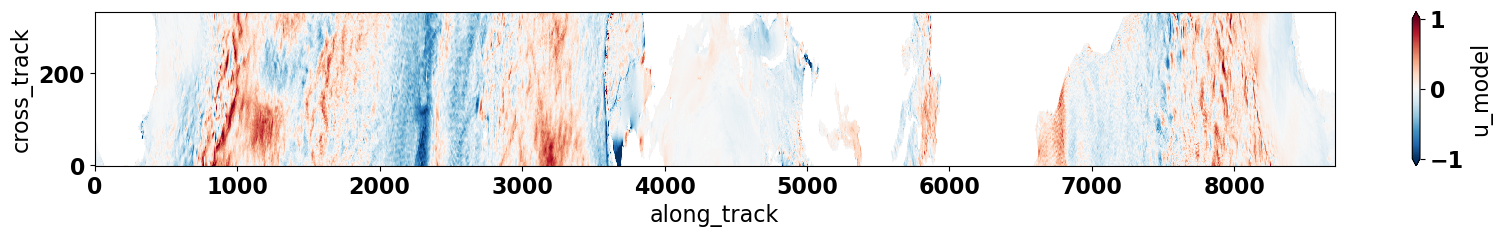

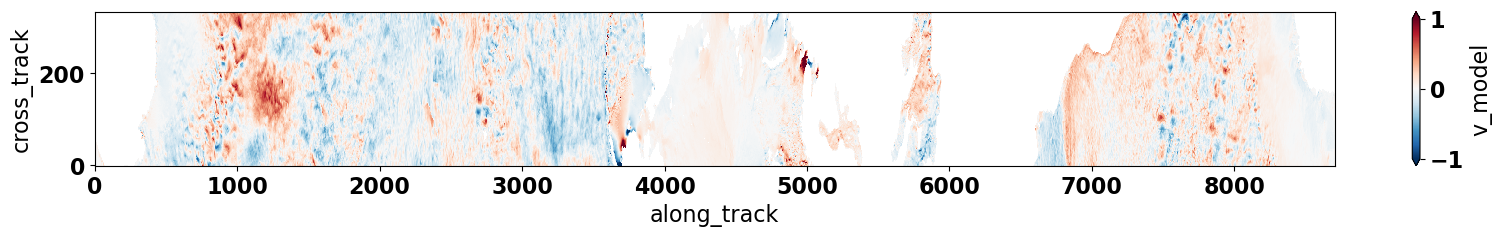

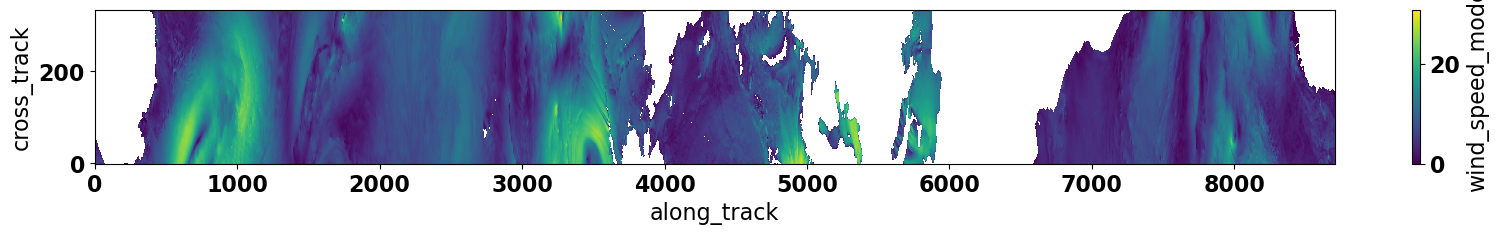

In [10]:
o.u_model.T.plot(figsize=(20,2),vmax=1,vmin=-1,cmap='RdBu_r')
o.v_model.T.plot(figsize=(20,2),vmax=1,vmin=-1,cmap='RdBu_r')
o.wind_speed_model.T.plot(figsize=(20,2))

## Look at these data on a geographic map

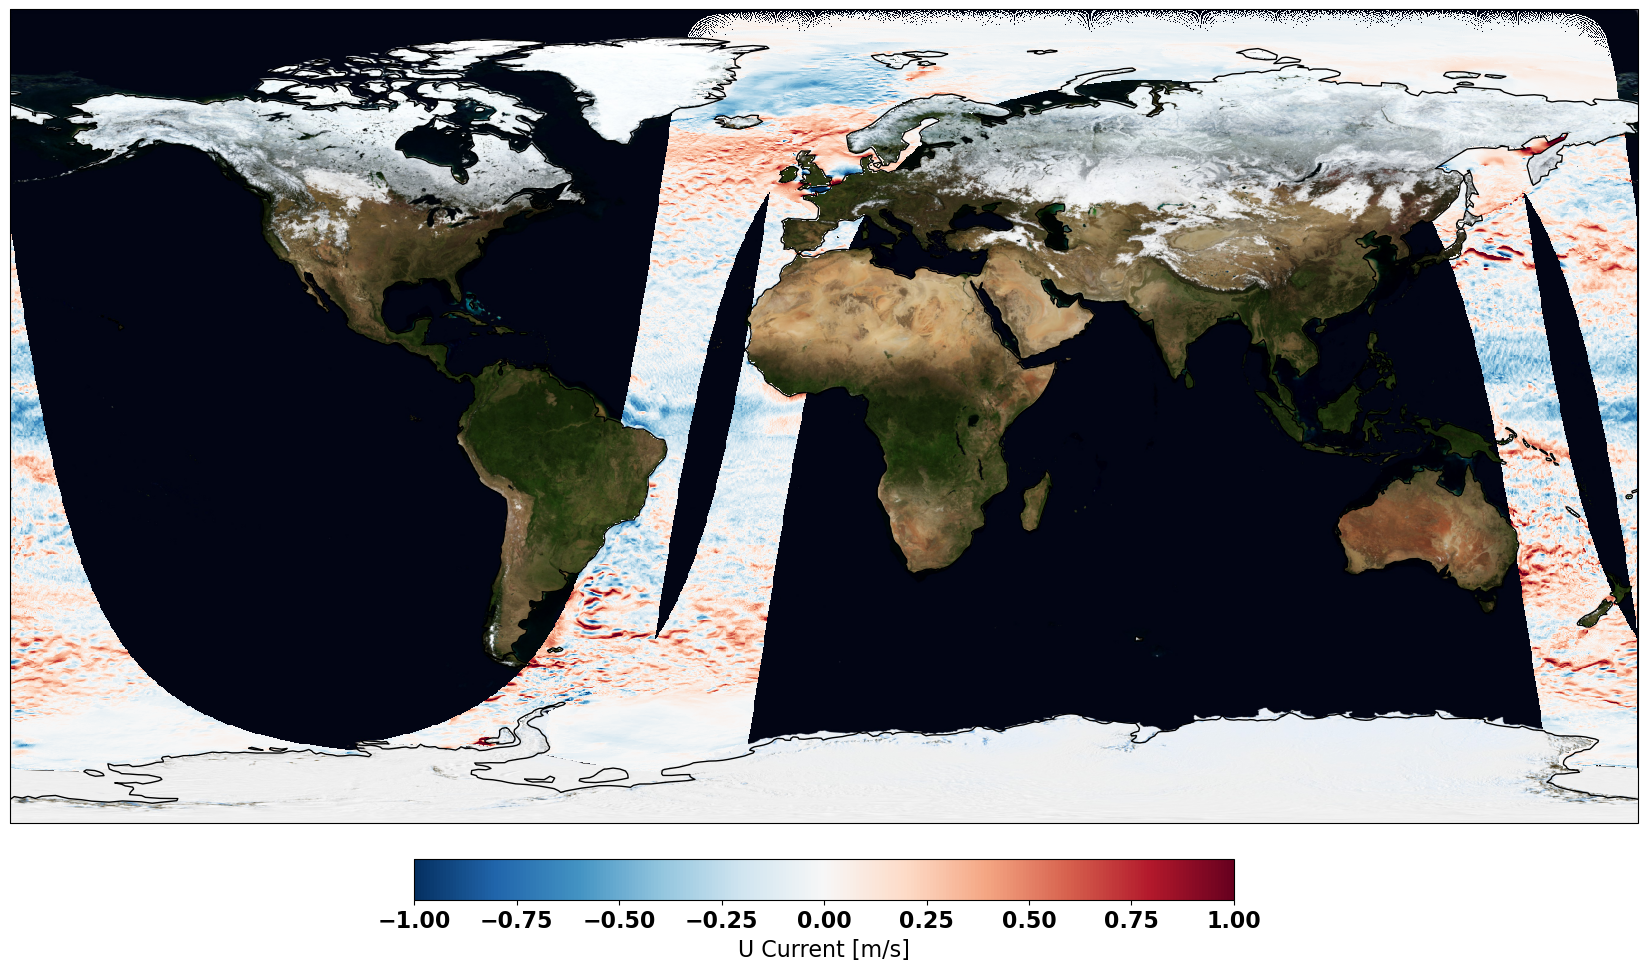

In [11]:
lons = []
lats = []
var_to_plot = []

# stack up some data from 2 orbits
for o in itertools.islice(orbits, 2):    

    o = model.colocateSwathCurrents(o)

    lons = np.append(lons,o.lon)
    lats = np.append(lats,o.lat)
    var_to_plot = np.append(var_to_plot,o.u_model)


# make a map with utils.makePlot(); this will grid data for us.
makePlot(lons,lats,var_to_plot,vmin=-1,vmax=1,cblabel='U Current [m/s]',colormap='RdBu_r',figsize=(20,10),bg=True,gridMe=True)

## Initialize an OdyseaErrors class that will do uncertainty estimation.

In [15]:
e = OdyseaErrors()

## Set surface current uncertainties (radial and geographic) using a simple constant wind speed error model.
This will set all expected standard deviations and resulting uncertainties. Using simulated_baseline will generate uncertainties that are a function of cross-track location and wind speed. If winds have been co-located to the swath from a model, those wind speeds and directions will be used to generate the error field, otherwise, a constant wind speed/dir will be used from the function arguments.

In [16]:
o = next(orbits)
o = e.setCurrentErrors(o,etype='simulated_baseline',wind_speed=7,wind_dir=0)
display(o)

Using wind speed from function args. Assign "wind_speed" and "wind_dir" variables to orbit dataset if desired.


<xarray.Dataset>
Dimensions:         (along_track: 8706, cross_track: 334)
Coordinates:
  * along_track     (along_track) int64 0 1 2 3 4 5 ... 8701 8702 8703 8704 8705
  * cross_track     (cross_track) int64 0 1 2 3 4 5 ... 328 329 330 331 332 333
Data variables: (12/17)
    sample_time     (along_track, cross_track) datetime64[ns] 2020-01-23T03:0...
    lat             (along_track, cross_track) float32 -78.95 -78.98 ... -81.58
    lon             (along_track, cross_track) float32 -93.55 -93.72 ... -91.58
    swath_blanking  (cross_track) bool True True True True ... True True True
    encoder_fore    (along_track, cross_track) float64 -90.0 -83.72 ... 90.0
    encoder_aft     (along_track, cross_track) float64 -90.0 -96.28 ... 90.0
    ...              ...
    vx_std          (along_track, cross_track) float64 1.001e+15 ... 1.815e+15
    vy_std          (along_track, cross_track) float64 -0.06128 ... 0.1111
    u_std           (along_track, cross_track) float64 1.478e+08 ... 1.229e+15
    v_std           (along_track, cross_track) float64 1.001e+15 ... 1.336e+15
    u_error         (along_track, cross_track) float64 -1.081e+08 ... 3.766e+13
    v_error         (along_track, cross_track) float64 1.966e+14 ... -1.467e+15
Attributes: (12/14)
    title:                Odysea Simple Orbit Sampling V0.1
    project:              Odysea
    summary:              Simplified orbit sampling assuming basic Odysea orb...
    references:           Rodriguez 2018, Wineteer 2020
    institution:          Jet Propulsion Laboratory (JPL)
    creator_name:         Alexander Wineteer
    ...                   ...
    geospatial_lat_min:   -89.99N
    geospatial_lat_max:   89.99N
    geospatial_lon_min:   -180.00E
    geospatial_lon_max:   180.00E
    time_coverage_start:  2020-01-23 03:02:59.999735
    time_coverage_end:    2020-01-23 04:37:58.873391

## Show the geographic u/v surface current uncertainties.

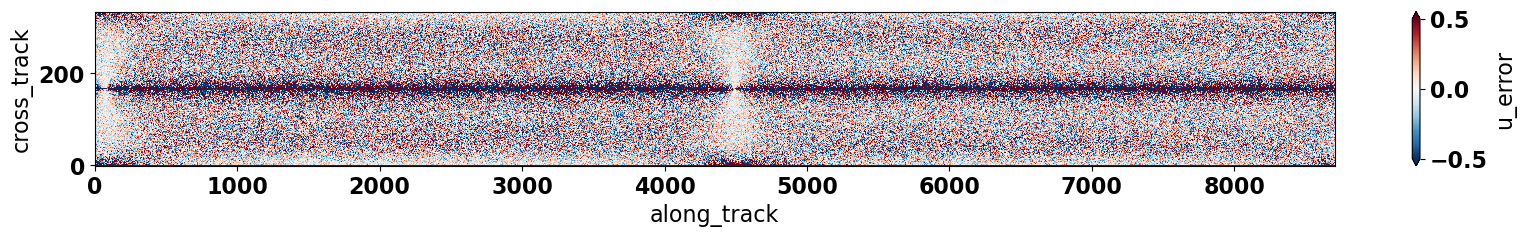

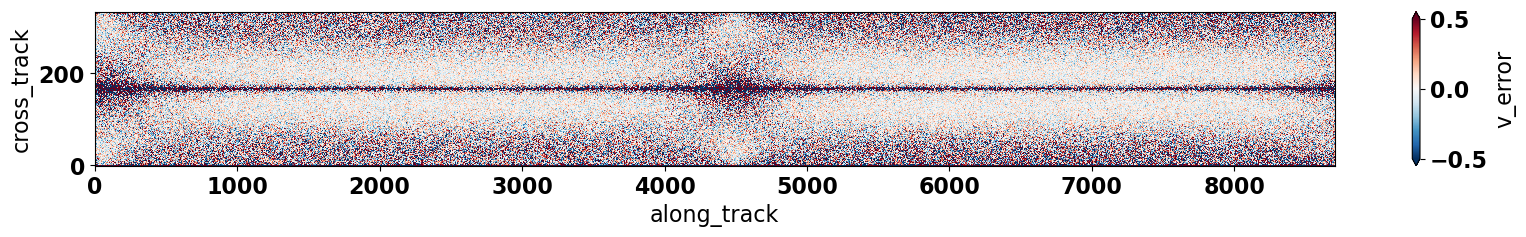

In [19]:
o.u_error.T.plot(figsize=(20,2),vmax=.5)
o.v_error.T.plot(figsize=(20,2),vmax=.5)

## Repeat the error estimation, but this time, co-locate model winds to the swath and use them during uncertainty estimation.

In [21]:
o = model.colocateSwathCurrents(o)
o = model.colocateSwathWinds(o)

o = e.setCurrentErrors(o,etype='simulated_baseline',wind_speed=7,wind_dir=0)
display(o)

<xarray.Dataset>
Dimensions:           (along_track: 8706, cross_track: 334)
Coordinates:
  * along_track       (along_track) int64 0 1 2 3 4 ... 8701 8702 8703 8704 8705
  * cross_track       (cross_track) int64 0 1 2 3 4 5 ... 329 330 331 332 333
Data variables: (12/25)
    sample_time       (along_track, cross_track) datetime64[ns] 2020-01-23T03...
    lat               (along_track, cross_track) float32 -78.95 ... -81.58
    lon               (along_track, cross_track) float32 -93.55 ... -91.58
    swath_blanking    (cross_track) bool True True True True ... True True True
    encoder_fore      (along_track, cross_track) float64 -90.0 -83.72 ... 90.0
    encoder_aft       (along_track, cross_track) float64 -90.0 -96.28 ... 90.0
    ...                ...
    u10_model         (along_track, cross_track) float64 nan nan nan ... nan nan
    v10_model         (along_track, cross_track) float64 nan nan nan ... nan nan
    tx_model          (along_track, cross_track) float64 nan nan nan ... nan nan
    ty_model          (along_track, cross_track) float64 nan nan nan ... nan nan
    wind_speed_model  (along_track, cross_track) float64 nan nan nan ... nan nan
    wind_dir_model    (along_track, cross_track) float64 nan nan nan ... nan nan
Attributes: (12/14)
    title:                Odysea Simple Orbit Sampling V0.1
    project:              Odysea
    summary:              Simplified orbit sampling assuming basic Odysea orb...
    references:           Rodriguez 2018, Wineteer 2020
    institution:          Jet Propulsion Laboratory (JPL)
    creator_name:         Alexander Wineteer
    ...                   ...
    geospatial_lat_min:   -89.99N
    geospatial_lat_max:   89.99N
    geospatial_lon_min:   -180.00E
    geospatial_lon_max:   180.00E
    time_coverage_start:  2020-01-23 03:02:59.999735
    time_coverage_end:    2020-01-23 04:37:58.873391

## Show the geographic u/v surface current uncertainties.

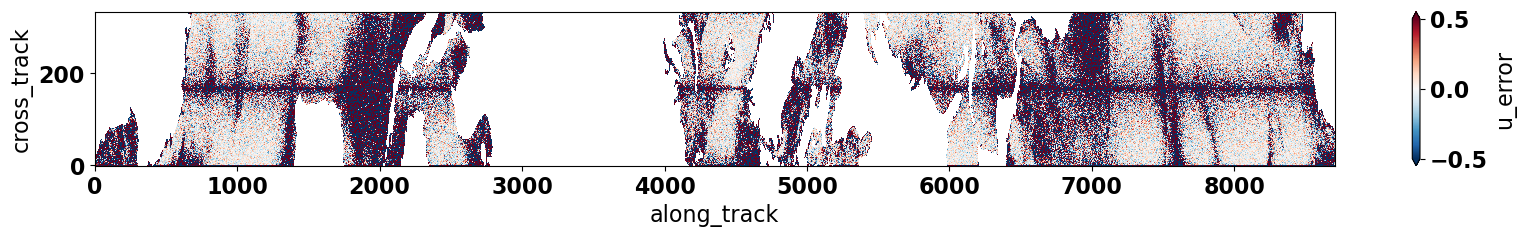

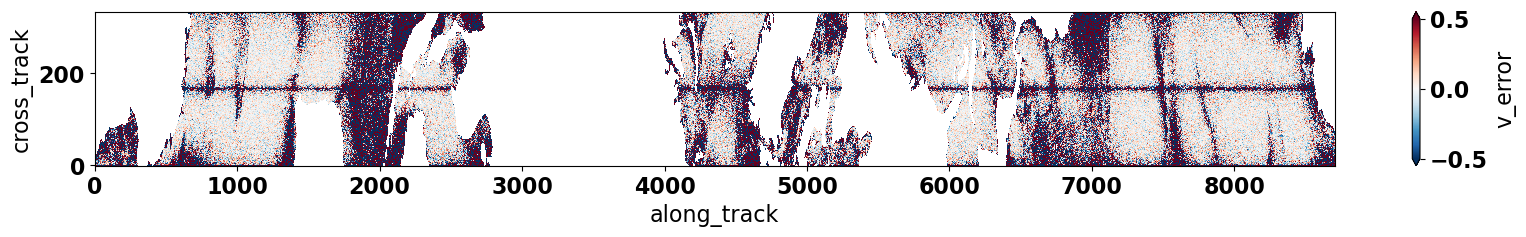

In [23]:
o.u_error.T.plot(figsize=(20,2),vmax=.5)
o.v_error.T.plot(figsize=(20,2),vmax=.5)